# Comparing the different Polymath projects and their evolution

## 1. Preparing the data
We start by setting up, loading the urls of the discussions, and putting everything in a frame.

In [1]:
import yaml
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 20)

from bs4 import BeautifulSoup
from collections import Counter
from concurrent import futures
from itertools import chain, product
import json
import networkx as nx
import pandas as pd
from pandas import DataFrame
from urllib.parse import urlparse
import datetime

from comment_thread import *
from author_network import *

**Note to self:** Keep in mind that cashing requests leads to missing new content (at least in PM10)!

In [2]:
IS_RESEARCH = {'pm 1': [False, True, True, True, True, True, True, True, True, True, True, True, False, True, True, False, True, False, False, False, False, False],
               'mini_pm 1': [True, True, False],
               'pm 3' : [False, False, False, False, False, False, False, True, True, True, True],
               'pm 5' : [False, False, False, False, False, False,
                         True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True],
               'mini_pm 2': [False, False, False, False, True],
               'pm 6': [True, False],
               'mini_pm 3': [False, False, True],
               'mini_pm 4': [False, False, False, True, True],
               'pm 8' : [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True,
                        False, False, False, False, False,
                        True, True, True, True, True, True, True,
                        False,
                        True, True, True, True,
                        False, False, False],
              'pm 9' : [False, True, True]}

**Check csv-files for presence of quotes that may be unnecessary**

The function `process_polymath` takes a referes to a Polymath or Mini Polymath project as an argument (format: "pm i" or "mini_pm i") and returns a `pandas.DataFrame` with each row a discussion-thread and the following columns:
+ title: title of the thread.
+ url: url of the thread
+ blog: the blog where the thread takes place
+ research: whether it is a research-thread
+ number of comments: the number of comments in the current thread
+ number of comments (accumulated): the number of comments in the project up to and including current thread (`cumsum` of previous, but should coincide with result from accumulated mthread)
+ thread: a `CommentThread` object for the current thread
+ mthread (single): a `MultiCommentThread` object based on the current thread
+ mthread (accumulated): a `MultiCommentThread` object based on all threads up to and including the current thread
+ network: a `AuthorNetwork` object based on the accumulated mthread
+ r_mthread (accumulated): a `MultiCommentThread` object based on all research threads up to and including the current thread (`NaN` if current thread is not research)
+ r_network: a `AuthorNetwork` object based on the accumulated research mthread
+ d_mthread (accumulated): a `MultiCommentThread` object based on all non-research threads up to and including the current thread (`NaN` if current thread is  research)
+ d_network: a `AuthorNetwork` object based on the accumulated non-research mthread

In [65]:
def process_polymath(project, split=False):
    message = "Polymath {}".format(project.split(" ")[-1]) if project.startswith("pm") else "Mini Polymath {}".format(project[-1])
    SETTINGS = {
    'msg' : message,
    'filename' : message.replace(" ", ""),
    'source' : project.replace(" ", ""),
    'urls' : [],
    'type' : '',
    'parser' : 'html5lib',
    'cmap' : plt.cm.Paired, # not a string, this is an object
    'vmin' : 1,
    'vmax' : 100}
    
    with open("DATA/" + SETTINGS['source'] + ".csv", "r") as input:
        pm_frame = pd.read_csv(input, index_col="Ord")
    
    #with open("DATA/"+ SETTINGS['source'] + ".txt", "r") as input:
    #    soup = BeautifulSoup(input.readline(), "html.parser")
    
    #items = soup.find("ul").find_all("li")
    #urls, titles = zip(*[(item.get("href"), item.text) for item in soup.find_all("a")])
    
    #research = IS_RESEARCH[project] if project in IS_RESEARCH else ["discussion" not in title.lower() for title in titles]
        
    #pm_frame = DataFrame({
    #    'url': urls,
    #    'title' : titles,
    #    'blog' : [urlparse(url).netloc.split('.')[0].title() for url in urls],
    #    'research' : research},
    #    columns = ['title', 'url', 'blog', 'research'])
            
    pm_frame['blog'] = pm_frame['url'].apply(lambda url: urlparse(url).netloc.split('.')[0].title())
    with futures.ProcessPoolExecutor(max_workers=4) as executor:
            pm_frame['thread'] = list(executor.map(
                    lambda url, blog: THREAD_TYPES[blog](url),
                    pm_frame['url'], pm_frame['blog']))
    #pm_frame['thread'] = [THREAD_TYPES[blog](url) for (url, blog) in zip(pm_frame['url'], pm_frame['blog'])]
    pm_frame['number of comments'] = pm_frame['thread'].apply(lambda x: len(x.node_name.keys()))
    pm_frame['number of comments (accumulated)'] = pm_frame['number of comments'].cumsum()
        
    indices = pm_frame.index
    threads = pm_frame.thread
    pm_frame['mthread (single)'] = pm_frame['thread'].apply(MultiCommentThread)
    pm_frame['mthread (accumulated)'] = Series([MultiCommentThread(*threads[0:i+1]) for i in indices],
                                               index=indices)
    pm_frame['network'] = pm_frame['mthread (accumulated)'].apply(AuthorNetwork)
    
    if split:
        r_indices = pm_frame[pm_frame['research']].index
        d_indices = pm_frame[~pm_frame['research']].index
        r_threads = pm_frame[pm_frame['research']].thread
        d_threads = pm_frame[~pm_frame['research']].thread
        pm_frame['r_mthread (accumulated)'] = Series([MultiCommentThread(*r_threads[0:i+1]) for i in r_indices],
                                                 index=r_indices)
        pm_frame['d_mthread (accumulated)'] = Series([MultiCommentThread(*d_threads[0:i+1]) for i in d_indices],
                                                 index=d_indices)
        pm_frame['r_network'] = pm_frame[pm_frame['research']]['r_mthread (accumulated)'].apply(AuthorNetwork)
        pm_frame['d_network'] = pm_frame[~pm_frame['research']]['d_mthread (accumulated)'].apply(AuthorNetwork)
        pm_frame = pm_frame.reindex_axis(['title', 'url', 'blog', 'research',
                                          'number of comments', 'number of comments (accumulated)',
                                          'thread', 'mthread (single)',
                                          'mthread (accumulated)', 'network',
                                          'r_mthread (accumulated)', 'r_network',
                                          'd_mthread (accumulated)', 'd_network'],
                                         axis=1)
    else:
        pm_frame = pm_frame.reindex_axis(['title', 'url', 'blog', 'research', 'number of comments',
                                      'thread', 'mthread (single)',
                                      'mthread (accumulated)', 'network'],
                                     axis=1)

    pm_frame.index = pd.MultiIndex.from_tuples([(SETTINGS['msg'], i) for i in indices],
                                               names=['Project', 'Ord'])
    
    return pm_frame

In [12]:
PM1_FRAME = process_polymath("pm 1", split=True)

with 4 workers: 1 loop, best of 3: 1min 10s per loop

In [ ]:
PM2_FRAME = process_polymath("pm 2", split=True)

Traceback (most recent call last):
  File "/Users/patrickallo/anaconda/envs/python3/lib/python3.5/multiprocessing/queues.py", line 241, in _feed
    obj = ForkingPickler.dumps(obj)
  File "/Users/patrickallo/anaconda/envs/python3/lib/python3.5/multiprocessing/reduction.py", line 50, in dumps
    cls(buf, protocol).dump(obj)
AttributeError: Can't pickle local object 'process_polymath.<locals>.<lambda>'


In [14]:
mPM1_FRAME = process_polymath("mini_pm 1", split=True)

error with eigenvector centrality: eigenvector_centrality():
power iteration failed to converge in %d iterations."%(i+1))
error with eigenvector centrality: eigenvector_centrality():
power iteration failed to converge in %d iterations."%(i+1))


In [15]:
PM3_FRAME = process_polymath("pm 3", split=True)

In [16]:
PM4_FRAME = process_polymath("pm 4", split=True)

In [17]:
PM5_FRAME = process_polymath("pm 5", split=True)

In [18]:
mPM2_FRAME = process_polymath("mini_pm 2", split=True)

error with eigenvector centrality: eigenvector_centrality():
power iteration failed to converge in %d iterations."%(i+1))
error with eigenvector centrality: eigenvector_centrality():
power iteration failed to converge in %d iterations."%(i+1))


In [19]:
PM6_FRAME = process_polymath("pm 6", split=True)

In [20]:
mPM3_FRAME = process_polymath("mini_pm 3", split=True)

error with eigenvector centrality: eigenvector_centrality():
power iteration failed to converge in %d iterations."%(i+1))
error with eigenvector centrality: eigenvector_centrality():
power iteration failed to converge in %d iterations."%(i+1))


In [21]:
mPM4_FRAME = process_polymath("mini_pm 4", split=True)

error with degree centrality:  float division by zero
error with degree centrality:  float division by zero


In [22]:
PM7_FRAME = process_polymath("pm 7", split=True)

In [64]:
PM8_FRAME = process_polymath("pm 8", split=True)

In [24]:
PM9_FRAME = process_polymath("pm 9", split=True)

In [25]:
PM10_FRAME = process_polymath("pm 10", split=True)

In [26]:
PM11_FRAME = process_polymath("pm 11", split=True)

A list of all Polymath and Mini Polymath frames is created, and then used to create two large `pandas.DataFrames`

In [27]:
POLYMATHS = [PM1_FRAME, PM2_FRAME, PM3_FRAME, PM4_FRAME, PM5_FRAME, PM6_FRAME, PM7_FRAME, PM8_FRAME, PM9_FRAME, PM10_FRAME, PM11_FRAME]
MINIPOLYMATHS = [mPM1_FRAME, mPM2_FRAME, mPM3_FRAME, mPM4_FRAME]
COL_ORDER = PM1_FRAME.columns.tolist()
PM_FRAME = pd.concat(POLYMATHS)[COL_ORDER]
mPM_FRAME = pd.concat(MINIPOLYMATHS)

Additional columns with sets of authors for threads and accumulated mthreads are added

In [28]:
PM_FRAME['authors'] = PM_FRAME['thread'].apply(lambda thread: thread.authors)
PM_FRAME['authors (accumulated)'] = PM_FRAME['network'].apply(lambda network: set(network.author_frame.index))
mPM_FRAME['authors'] = mPM_FRAME['thread'].apply(lambda thread: thread.authors)
mPM_FRAME['authors (accumulated)'] = mPM_FRAME['network'].apply(lambda network: set(network.author_frame.index))

Sets of all PM-authors and all Mini-PM-authors are created.

In [29]:
ALL_AUTHORS = set.union(*PM_FRAME['authors'].tolist())
ALL_MINI_AUTHORS = set.union(*mPM_FRAME['authors'].tolist())

We check (using string-similarity) for authors that may appear under different names. The outcome of this has been used to further populate `author_convert.yaml` which is used during the parsing of the threads. What remains is not sufficient to warrant further additions to author_convert.

In [30]:
from itertools import combinations
from difflib import SequenceMatcher

for (str1, str2) in combinations(ALL_AUTHORS, 2):
    if SequenceMatcher(None, str1, str2).ratio() > .8:
        print(str1, str2)
        
for (str1, str2) in combinations(ALL_MINI_AUTHORS, 2):
    if SequenceMatcher(None, str1, str2).ratio() > .8:
        print(str1, str2)

Andreas Andre
Andreas Andrea
Johannes JohnJones
Andre Andrea
Jon John
Joel Joe
Richard G. Richard
Jon John
Thomas H Thomas
prospector Prospector
mstudent student


## 2. Creating additional functions
### 2.1. Wrapping object-methods into functions
We define functions that take a project as argument call a method form the appropriate object. 

In [31]:
def get_project_at(project, stage):
    return mPM_FRAME.loc[project].iloc[stage] if project.startswith("Mini") else PM_FRAME.loc[project].iloc[stage]

def draw_network(project, stage=-1):
    """Wrapper function for author_network.draw_graph.
    Plots the interaction-network between the commenters in project."""
    get_project_at(project, stage)['network'].draw_graph(project=project)
    
def draw_centre(project, stage=-1, skips=10, zoom=1):
    """Wrapper function for author_network.draw_centre_discussion"""
    get_project_at(project, stage)['network'].draw_centre_discussion(skips=skips, zoom=zoom)

def plot_activity_pie(project, stage=-1):
    """Wrapper function for author_network.plot_author_activity_pie
    Plots pie-chart of comment_activity of commenters is project."""
    get_project_at(project, stage)['network'].plot_author_activity_pie(project=project)
    
def plot_activity_bar(project, stage=-1):
    """Wrapper function for author_network.plot_activity_bar
    Plots bar-chart of comment_activity of commenters in project"""
    get_project_at(project, stage)['network'].plot_author_activity_bar(project=project)

def plot_degree_centrality(project, stage=-1):
    """Wrapper function for author_network.plot_degree_centrality
    Plots line-chart of degree-centrality of commenters in project"""
    get_project_at(project, stage)['network'].plot_degree_centrality(project=project)

def plot_activity_degree(project, stage=-1):
    """Wrapper function for author_network.plit_activity_degree
    Plots superposition of bar-chart of comment-activity and line-chart of degree-centrality"""
    get_project_at(project, stage)['network'].plot_activity_degree(project=project)

def plot_discussion(project, intervals=10, first=SETTINGS['first_date'], last=SETTINGS['last_date'], stage=-1):
    """Wrapper function for mthread.draw_graph
    Plots structure of discussion in project"""
    get_project_at(project, stage)['mthread (accumulated)'].draw_graph(intervals=intervals,
                                                                       first=first,
                                                                       last=last,
                                                                       project=project)

def plot_activity(project, intervals=1, first=SETTINGS['first_date'], last=SETTINGS['last_date'],
                  activity='thread', stage=-1):
    """Wrapper function for mthread.plot_activity
    Plots thread or author activity over time for project"""
    get_project_at(project, stage)['mthread (accumulated)'].plot_activity(activity, intervals=intervals,
                                                                          first=first,
                                                                          last=last,
                                                                          project=project)

def plot_growth(project, last= datetime.today(), stage=-1):
    """Wrapper function for mthread.plot_growth
    Plots growth in comments in discussion"""
    get_project_at(project, stage)['mthread (accumulated)'].plot_growth(project=project, last=last)

### 2.2 Creating additional functionality to show community engagement over time
We start with a small auxiliary function that returns the last row for each project from a large DateFrame.

In [32]:
def get_last(lst_of_frames):
    if lst_of_frames == POLYMATHS:
        source = PM_FRAME
        positions = np.array([frame.index.levels[1][-1] for frame in lst_of_frames]).cumsum() + np.arange(len(POLYMATHS))
    elif lst_of_frames == MINIPOLYMATHS:
        source = mPM_FRAME
        positions = np.array([frame.index.levels[1][-1] for frame in lst_of_frames]).cumsum() + np.arange(len(MINIPOLYMATHS))
    else:
        raise ValueError("Need either POLYMATHS or MINIPOLYMATHS")
    source.index = source.index.swaplevel(0,1)
    data = source.iloc[positions]
    source.index = source.index.swaplevel(1,0)
    data.index = data.index.droplevel()
    return data, positions


Four complementary functions are defined which visualise how *community engagement* (how many participants, how diverse, who leaves, who joins) in projects or groups of projects evolves over time.

The function `plot_thread_engagement` takes a project as argument, and shows four types of data for each thread in bar-plot:
1. y-axis: the average number of comments per participant (a measure of how diverse each thread is)
2. width of each bar: the number of comments
3. bar-color: the type of thread
4. text above each bar included in the optional kwarg `sel`: number of comments and number of participants.

In [33]:
def plot_thread_engagement(project, compress=1, sel=[]):
    data = mPM_FRAME.loc[project] if project.startswith("Mini") else PM_FRAME.loc[project]
    authors = data['authors'].apply(len)
    engagement = authors / data['number of comments']
    df = DataFrame({'research threads': engagement[data['research']],
                    'discussion threads': engagement[~data['research']]},
                   #columns = ['research threads', 'discussion threads'],
                   index=data.index)
    sizes = (data['number of comments'] / compress).tolist()
    df.index.name = "Threads"
    matplotlib.style.use('seaborn-notebook')
    fig = plt.figure()
    axes = df.plot(kind='bar', color=['lightsteelblue', 'steelblue'],
                   title = "Community engagement in {}".format(project))
    axes.set_ylabel('average number of comments per participant')
    axes.set_yticklabels([round(1/i, 2) for i in axes.get_yticks()])
    axes.set_xticklabels(data['title'].apply(lambda x: x[:40]), rotation=90, fontsize='small')
    for container in axes.containers:
        for i, child in enumerate(container.get_children()):
            child.set_x(df.index[i] - sizes[i]/2)
            plt.setp(child, width=sizes[i])
    for i in engagement.index:
            if i in sel:
                axes.text(engagement.index[i] + .2, engagement[i],
                          "{} comments\n {} commenters".format(data['number of comments'][i], authors[i]),
                          ha="center", va="bottom", fontsize='small')
    plt.tight_layout()

The function `plot_thread_evolution` takes a project as argument and shows two plots:
1. The bar-plot `thread_engagement` described above
2. The evolution of the number of participants in each thread (active, joined, left) as an area-plot

In [34]:
def plot_thread_evolution(project, compress=1, sel=[], sharex=True):
    # data for evolution
    data = mPM_FRAME.loc[project] if project.startswith("Mini") else PM_FRAME.loc[project]
    added = (data['authors'] - data['authors'].shift(1)).apply(lambda x: 0 if isinstance(x, float) else len(x))
    removed = (data['authors'].shift(1) - data['authors']).apply(lambda x: 0 if isinstance(x, float) else - len(x))
    size = data['authors'].apply(len) - added
    df1 = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                   columns=["joined", "current", "left"], index=data.index)
    df1.index.name = "Threads"
    # data for engagement
    authors = data['authors'].apply(len)
    engagement = authors / data['number of comments']
    df2 = DataFrame({'research threads': engagement[data['research']],
                    'discussion threads': engagement[~data['research']]},
                   #columns = ['research threads', 'discussion threads'],
                   index=data.index)
    sizes = (data['number of comments'] / compress).tolist()
    df2.index.name = "Threads"
    # setting up plot
    matplotlib.style.use('seaborn-talk')
    fig, axes = plt.subplots(2, 1, figsize=(15, 6), squeeze=False, sharex=sharex)
    plt.subplots_adjust(hspace=0.2)
    # plot bottom
    df1.plot(kind="area", ax = axes[1][0], title="",
            color=['sage', 'lightgrey', 'indianred'], stacked=True)
    axes[1][0].set_xticks(df1.index)
    axes[1][0].set_xticklabels(data['title'], rotation=90, fontsize='small')
    axes[1][0].set_xlabel("")
    axes[1][0].set_ylabel('active commenters')
    # plot top
    df2.plot(kind='bar', ax = axes[0][0], color=['lightsteelblue', 'steelblue'],
                   title = "Community engagement in {}".format(project))
    axes[0][0].set_ylabel('comments per participant')
    axes[0][0].set_yticklabels([round(1/i, 2) for i in axes[0][0].get_yticks()])
    axes[0][0].yaxis.get_major_ticks()[0].label1.set_visible(False)
    axes[0][0].set_xticklabels(df2.index, fontsize='small')
    axes[0][0].set_xlabel("")
    for container in axes[0][0].containers:
        for i, child in enumerate(container.get_children()):
            child.set_x(df2.index[i] - sizes[i]/2)
            plt.setp(child, width=sizes[i])
    for i in engagement.index:
            if i in sel:
                axes[0][0].text(engagement.index[i] + .2, engagement[i],
                          "{} comments\n {} commenters".format(data['number of comments'][i], authors[i]),
                          ha="center", va="bottom", fontsize='small')

The function `plot_community_evolution` can both take a project, and a group of projects ("Polymath" of "MiniPolymath") as an argument, and shows the evolution of the number of participants per thread or per project in the same manner as the area-plot in `plot_thread_evolution`.

In [35]:
def plot_community_evolution(project):
    if isinstance(project.split()[-1], int):
        as_threads = True
        data = mPM_FRAME.loc[project] if project.startswith("Mini") else PM_FRAME.loc[project]
        added = (data['authors'] - data['authors'].shift(1)).apply(lambda x: 0 if isinstance(x, float) else len(x))
        removed = (data['authors'].shift(1) - data['authors']).apply(lambda x: 0 if isinstance(x, float) else - len(x))
        size = data['authors'].apply(len) - added
        df = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                       columns=["joined", "current", "left"], index=data.index)
        df.index.name = "Threads"
    else:
        as_threads = False
        if project.startswith("Mini"):
            data, positions = get_last(MINIPOLYMATHS)
        elif project.startswith("Poly"):
            data, positions = get_last(POLYMATHS)
        else:
            raise ValueError("Need either Polymath or Mini Polymath")
        added = (data['authors (accumulated)'] - data['authors (accumulated)'].shift(1)).apply(lambda x: 0 if isinstance(x, float) else len(x))
        removed = (data['authors (accumulated)'].shift(1) - data['authors (accumulated)']).apply(lambda x: 0 if isinstance(x, float) else - len(x))
        size = data['authors (accumulated)'].apply(len) - added
        df = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                       columns=["joined", "current", "left"])
        df.index = list(range(1, len(positions) + 1))
    
    matplotlib.style.use('seaborn-notebook')
    fig = plt.figure()
    axes = df.plot(kind="area", title="Community Evolution in {}".format(project),
            color=['sage', 'lightgrey', 'indianred'], stacked=True)
    axes.set_xticks(df.index)
    if as_threads:
        axes.set_xticklabels(data['title'], rotation=90, fontsize='small')
    else:
        xlabels = sorted(data.index, key=lambda x: int(x.split()[-1]))
        axes.set_xticklabels(xlabels, rotation=90, fontsize='small')
    axes.set_ylabel('number of active commenters')



The function `plot_participation_evolution` can both take a project, and a group of projects ("Polymath" of "MiniPolymath") as an argument, and shows for each participant that took part in at least `n` projects/threads the projects/threads (s)he participated in.

In [36]:
def plot_participation_evolution(project, n=2, skip_anon=True):
    if project.split()[-1]in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']:
        print("process threads")
        as_threads = True
        if project.startswith("Mini"):
            data = mPM_FRAME.loc[project]
        elif project.startswith("Poly"):
            data = PM_FRAME.loc[project]
        else:
            raise ValueError("Need either Polymath or Mini Polymath project")
        all_authors = data.iloc[-1]['authors (accumulated)']
        data = data['authors']
        title = "Participation per thread in " + project
    else:
        as_threads = False
        if project.startswith("Mini"):
            data, positions = get_last(MINIPOLYMATHS)
            all_authors = list(ALL_MINI_AUTHORS)
            title = "Participation per project in Mini Polymath"
        elif project.startswith("Poly"):
            data, positions = get_last(POLYMATHS)
            all_authors = list(ALL_AUTHORS)
            title = "Participation per project in Polymath"
        else:
            raise ValueError("Need either Polymath or Mini Polymath")
        data = data['authors (accumulated)']
    indices = data.index.tolist()
    author_project = DataFrame(index=all_authors)
    for ind in indices:
        author_project[ind] = np.zeros_like(author_project.index, dtype=bool)
        for author in data[ind]:
            author_project[ind][author] = True
    author_project = author_project.sort_values(by=indices, ascending=False)
    author_project = author_project.drop("Anonymous") if skip_anon else author_project
    select = author_project.sum(axis=1) >= n
    matplotlib.style.use('seaborn-notebook')
    factor = 30 - len(indices) if len(indices) <= 30 else 40 - len(indices)
    colors = [plt.cm.Set1(factor*i) for i in range(len(indices))]
    author_project.loc[select].plot(kind="bar", stacked=True, color=colors,
                                    title=title)

In [37]:
def summarise_project(project):
    data = PM_FRAME.loc[project][['authors', 'number of comments']]
    data['author count'] = data['authors'].apply(lambda set: len(set))
    return data[['author count', 'number of comments']].describe()

## 3. General comparisons
### 3.1 Sizes of project

We start by just looking at the number of comments for the whole of Polymath and the whole of Mini Polymath

**does it make sense to plot this as well, and split up between research and discussion?**

We then look at the number of participats and number of comments per project (and split up between research and discussion threads for the participants).

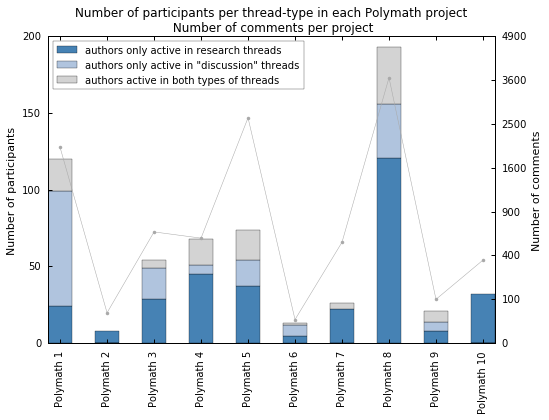

In [38]:
from matplotlib.ticker import FuncFormatter

PROJECTS_TO_C = ["Polymath {}".format(i) for i in range(1, 11)]
PARTICIPANTS = Series([PM_FRAME.loc[project]['authors (accumulated)'].iloc[-1] for
                project in PROJECTS_TO_C], index=PROJECTS_TO_C)
R_NETWORKS = Series([PM_FRAME.loc[project]['r_network'].dropna().iloc[-1] for project in PROJECTS_TO_C],
                    index=PROJECTS_TO_C)
WITH_D = [project for project in PROJECTS_TO_C if not PM_FRAME.loc[project]['research'].all()]
D_NETWORKS = Series([PM_FRAME.loc[project]['d_network'].dropna().iloc[-1] for project in WITH_D],
                    index=WITH_D)
R_PARTICIPANTS = R_NETWORKS.apply(lambda network: set(network.author_frame.index))
D_PARTICIPANTS = D_NETWORKS.apply(lambda network: set(network.author_frame.index))
COMMENTS = Series([PM_FRAME.loc[project]['number of comments (accumulated)'].iloc[-1] for
                project in PROJECTS_TO_C], index=PROJECTS_TO_C)

df = DataFrame({'all threads': PARTICIPANTS, 'research threads': R_PARTICIPANTS, 'discussion threads': D_PARTICIPANTS},
              index=PROJECTS_TO_C)
df['authors only active in research threads'] = df['research threads'] - df['discussion threads']
df['authors only active in "discussion" threads'] = df['discussion threads'] - df['research threads']
df['authors active in both types of threads'] = df['all threads'] - df['authors only active in research threads'] - df['authors only active in "discussion" threads']
for project in PROJECTS_TO_C:
    if pd.isnull(df.loc[project]['authors only active in research threads']):
        df.loc[project]['authors only active in research threads'] = df.loc[project]['all threads']
data = df[['authors only active in research threads', 'authors only active in "discussion" threads', 'authors active in both types of threads']]
data = data.applymap(lambda set: len(set) if pd.notnull(set) else 0)
matplotlib.style.use('seaborn-notebook')
axes = data.plot(kind='bar', stacked=True, color=['steelblue', 'lightsteelblue', 'lightgrey'],
          title="Number of participants per thread-type in each Polymath project\n Number of comments per project")
axes.set_ylabel("Number of participants")
data2 = np.sqrt(COMMENTS)
axes2 = axes.twinx()
axes2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos:"{:0.0f}".format(np.square(x))))
axes2.set_ylabel("Number of comments")
axes2.plot(axes.get_xticks(), data2.values,
                   linestyle='-', marker='.', linewidth=.5,
                   color='darkgrey')

+ The clearly successful cases, which led to one or more publications, are Polymath 1, 4 and 8.
+ Polymath 5 was an indirect success, since elements of it were later used by Terence Tao to prove Erdős’s discrepancy problem.
+ The status of Polymath 3 seems unclear, but there important results have been published by a participant to the discussion.
+ Polymath 2, 6 and 7 have either been stopped, or seem abandoned.
+ Polymath 10 is still active.

So far, we can only conclude that unsuccesful project end with only a small number of comments. In some cases this is because it quickly becomes clear that some initial assumptions were false, but in others it is more likely due to a lack of initial progress.

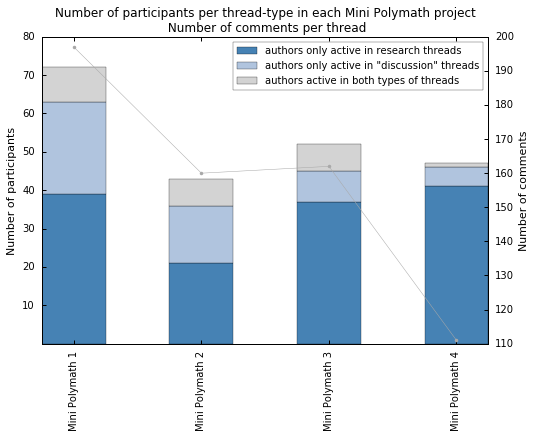

In [39]:
PROJECTS_TO_C = ["Mini Polymath {}".format(i) for i in range(1, 5)]
PARTICIPANTS = Series([mPM_FRAME.loc[project]['authors (accumulated)'].iloc[-1] for
                project in PROJECTS_TO_C], index=PROJECTS_TO_C)
R_NETWORKS = Series([mPM_FRAME.loc[project]['r_network'].dropna().iloc[-1] for project in PROJECTS_TO_C],
                    index=PROJECTS_TO_C)
WITH_D = [project for project in PROJECTS_TO_C if not mPM_FRAME.loc[project]['research'].all()]
D_NETWORKS = Series([mPM_FRAME.loc[project]['d_network'].dropna().iloc[-1] for project in WITH_D],
                    index=WITH_D)
R_PARTICIPANTS = R_NETWORKS.apply(lambda network: set(network.author_frame.index))
D_PARTICIPANTS = D_NETWORKS.apply(lambda network: set(network.author_frame.index))
COMMENTS = Series([mPM_FRAME.loc[project]['number of comments (accumulated)'].iloc[-1] for
                project in PROJECTS_TO_C], index=PROJECTS_TO_C)

df = DataFrame({'all threads': PARTICIPANTS, 'research threads': R_PARTICIPANTS, 'discussion threads': D_PARTICIPANTS},
              index=PROJECTS_TO_C)
df['authors only active in research threads'] = df['research threads'] - df['discussion threads']
df['authors only active in "discussion" threads'] = df['discussion threads'] - df['research threads']
df['authors active in both types of threads'] = df['all threads'] - df['authors only active in research threads'] - df['authors only active in "discussion" threads']
for project in PROJECTS_TO_C:
    if pd.isnull(df.loc[project]['authors only active in research threads']):
        df.loc[project]['authors only active in research threads'] = df.loc[project]['all threads']
data = df[['authors only active in research threads', 'authors only active in "discussion" threads', 'authors active in both types of threads']]
data = data.applymap(lambda set: len(set) if pd.notnull(set) else 0)
matplotlib.style.use('seaborn-notebook')
axes = data.plot(kind='bar', stacked=True, color=['steelblue', 'lightsteelblue', 'lightgrey'],
          title="Number of participants per thread-type in each Mini Polymath project\n Number of comments per thread")
axes.set_ylabel("Number of participants")
axes.yaxis.get_major_ticks()[0].label1.set_visible(False)
data2 = COMMENTS
axes2 = axes.twinx()
axes2.set_ylabel("Number of comments")
axes2.plot(axes.get_xticks(), data2.values,
                   linestyle='-', marker='.', linewidth=.5,
                   color='darkgrey')

### 3.2 Evolution of participants in each project across Polymath and Mini Polymath
Our next move is to look at how Polymath evolves as a community.

First, we only look at the size of the groups of participants over time. 

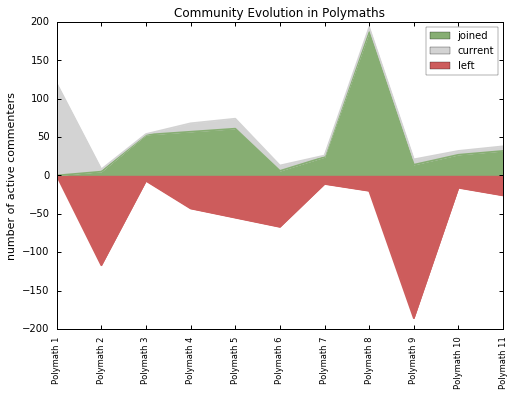

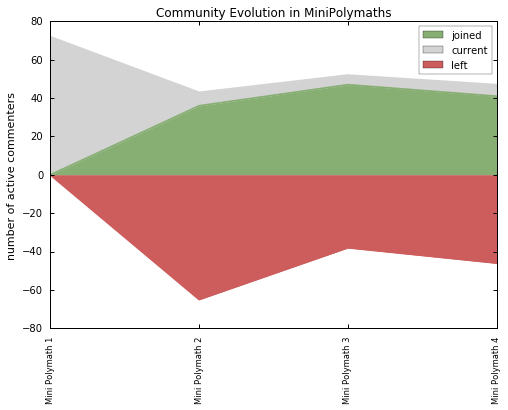

In [40]:
plot_community_evolution("Polymaths")
plot_community_evolution("MiniPolymaths")

This reveals, especially for the main projects, that the group of participants varies considerably over time, and that only a small core remains fixed.

Then we look at what remained constant over time in the group of participants. The plots below show for each participant active in at least 3 (Polymath) or 2 (Mini Polymath) projects, in which projects they were active.

Apart from the fact that no participant was active in all projects (only `Anonymous`, which was omited from the plots, did better than the trio Gowers, Tao and Kalai), we also see that 22 out of the 29 listed participants were there from the start. A similar pattern can be found in the mini projects.

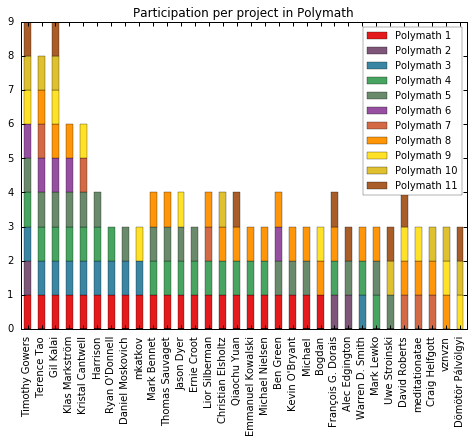

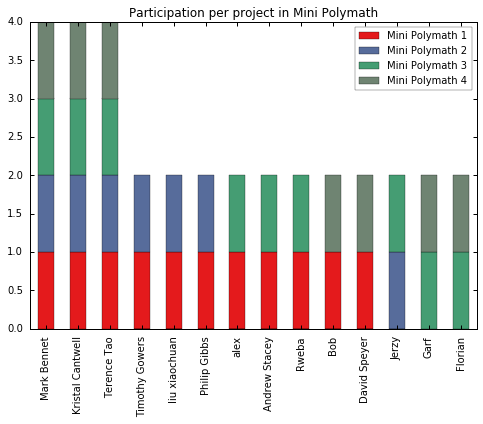

In [41]:
plot_participation_evolution("Polymath", n=3)
plot_participation_evolution("Mini Polymath", n=2)

If we expand our focus for the Polymath-projects and look at all participants active in at least 2 projects, 33 out of 60 were active from the start. We also see that participation need not be continuous or in consecutive projects. At first sight, it's also not the case that participation in a succesful project leads to particpation in the next project (several participants were active in 4 and 8 but not in between).

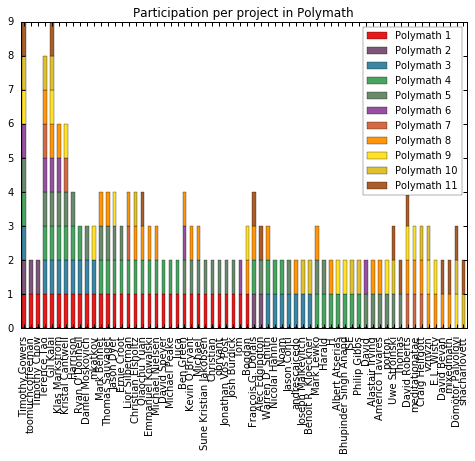

In [42]:
plot_participation_evolution("Polymath", n=2)

## 4. Focused comparisons

We now compare the structure and evolution of specific projects, and focus on the larger projects Polymath 1, 4 and 8 that led to published results.

Recall that the width of the bars corresponds to the number of comments in each thread, and that higher bars signal "more diverse" threads.

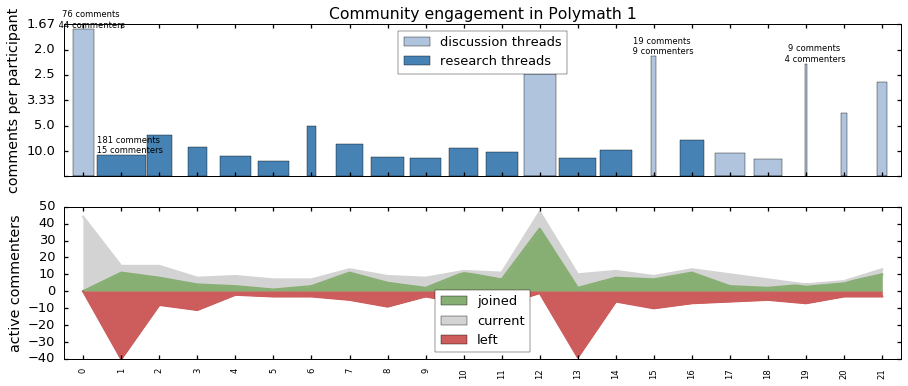

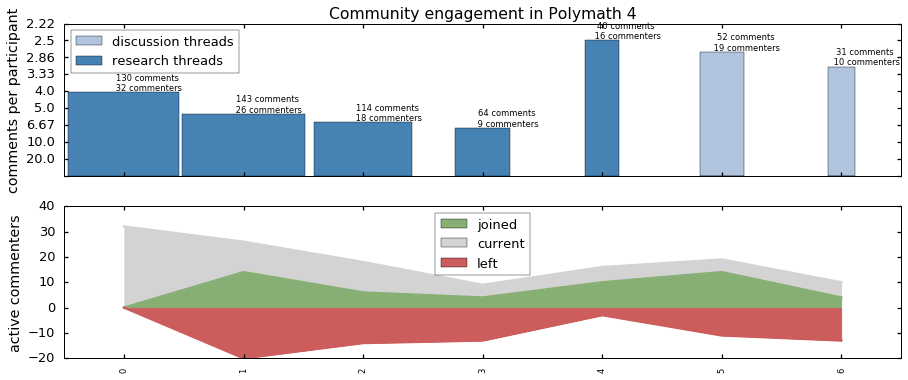

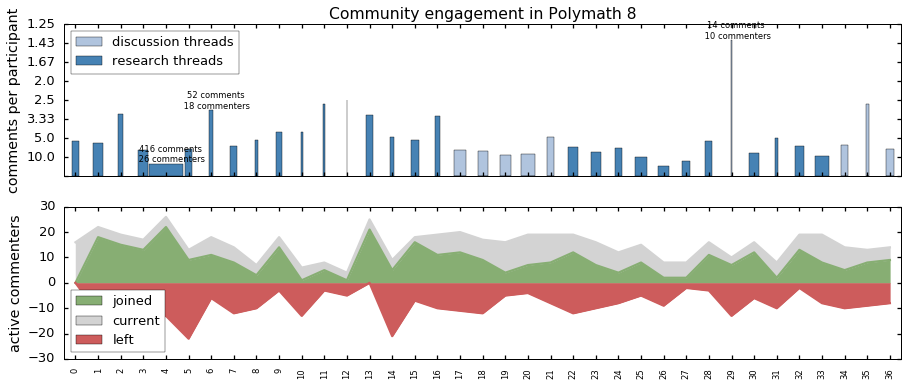

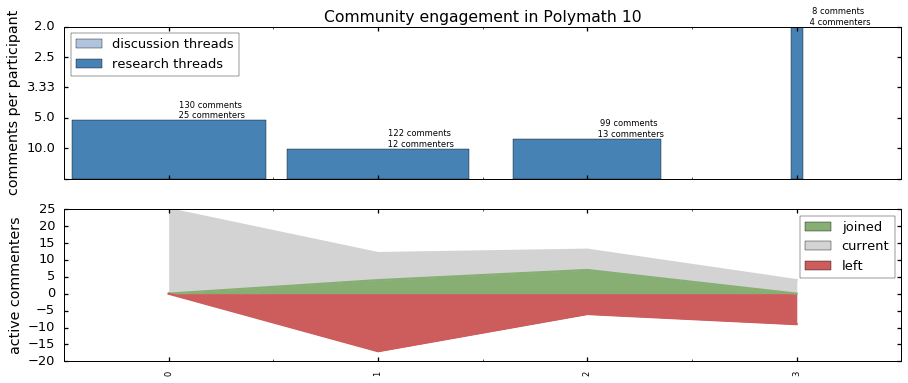

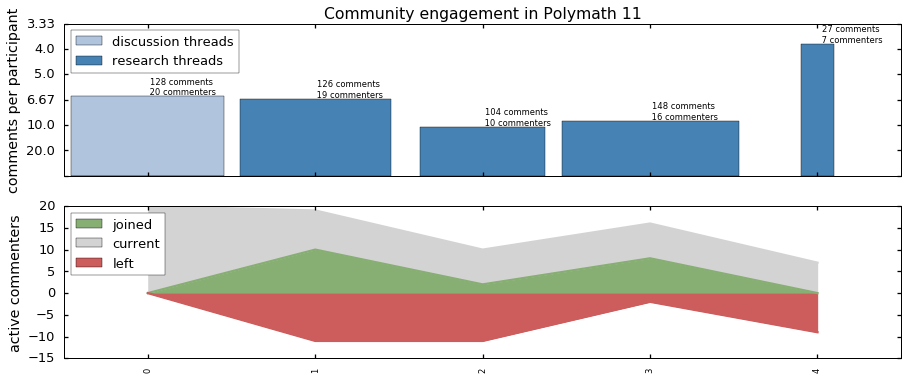

In [43]:
plot_thread_evolution("Polymath 1", compress=140, sel=[0, 1, 15, 19], sharex=True)
plot_thread_evolution("Polymath 4", compress=140, sel=[0, 1, 2, 3, 4, 5, 6], sharex=True)
plot_thread_evolution("Polymath 8", compress=280, sel=[4, 6, 29], sharex=True)
plot_thread_evolution("Polymath 10", compress=140, sel=[0, 1, 2, 3], sharex=True)
plot_thread_evolution("Polymath 11", compress=140, sel=[0, 1, 2, 3, 4], sharex=True)

This suggests that even in the larger successful projects, active participation goes up and down.

process threads
process threads
process threads
process threads
process threads


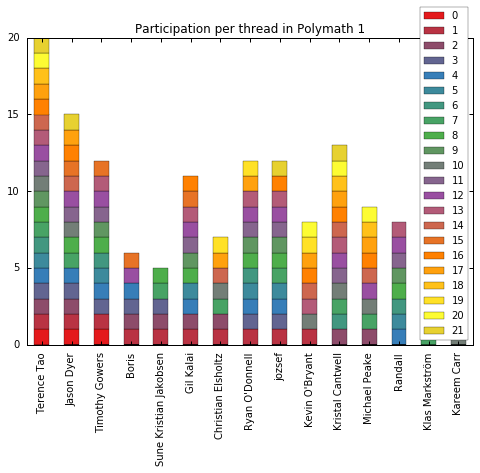

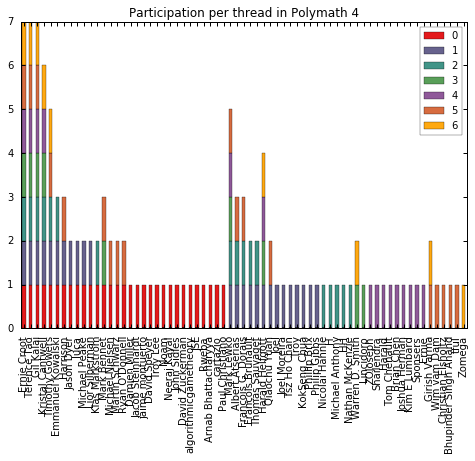

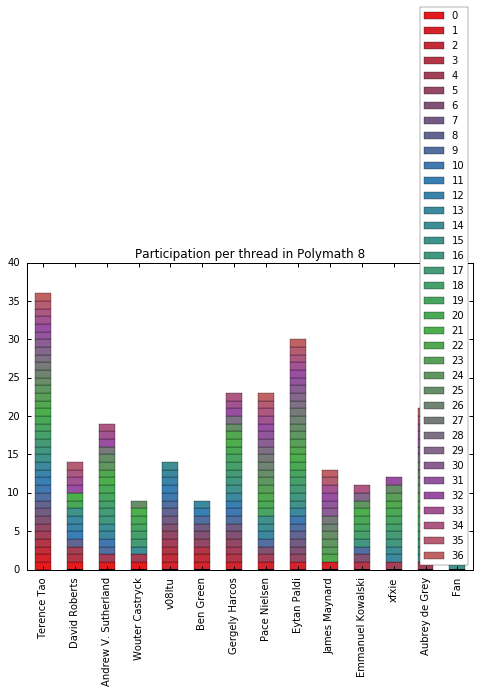

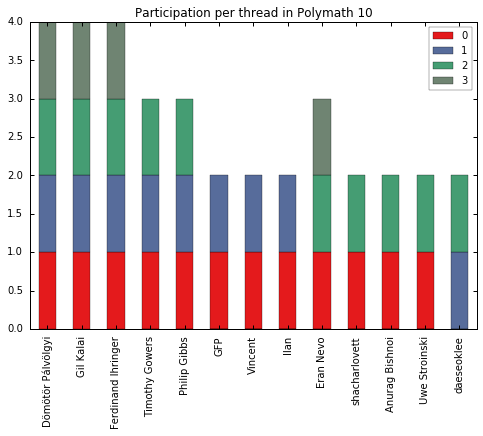

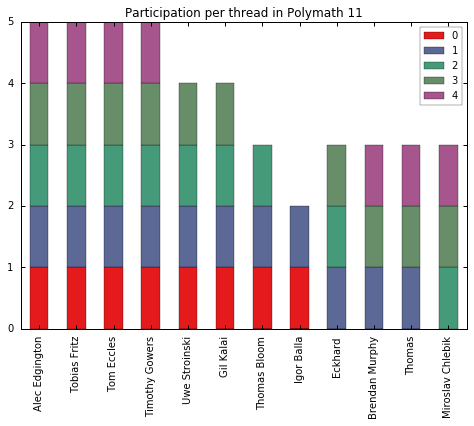

In [44]:
plot_participation_evolution("Polymath 1", n=5)
plot_participation_evolution("Polymath 4", n=1)
plot_participation_evolution("Polymath 8", n=7)
plot_participation_evolution("Polymath 10", n=2)
plot_participation_evolution("Polymath 11", n=2)

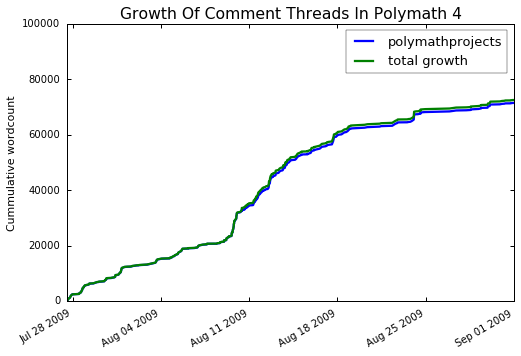

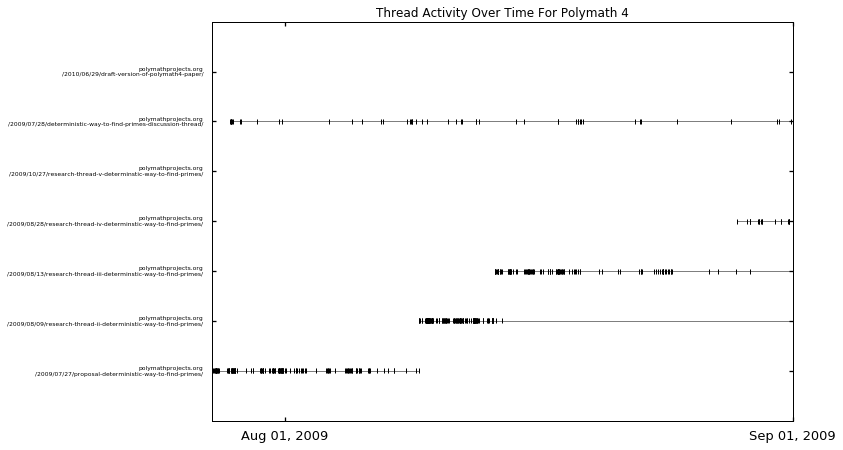

In [45]:
plot_growth('Polymath 4', last="2009-09-01")
plot_activity("Polymath 4", last="2009-09-01")
#plot_growth('Polymath 7', last="2012-07-15")
#plot_growth('Polymath 9', last="2013-12-31")

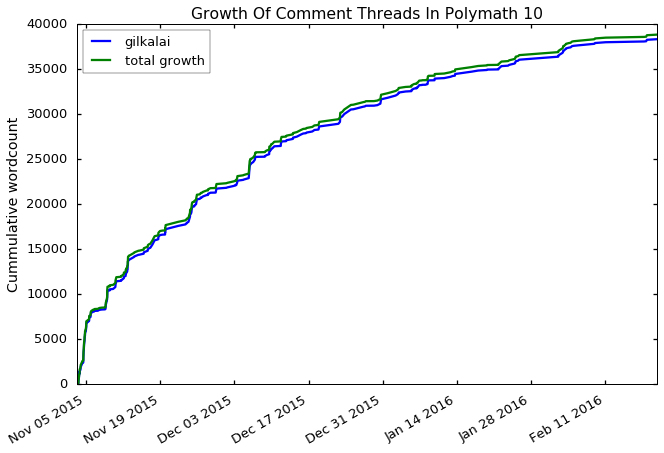

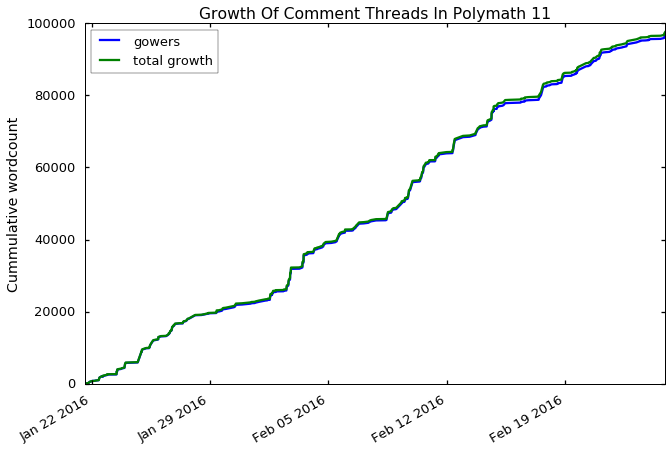

In [46]:
plot_growth('Polymath 10')
plot_growth('Polymath 11')

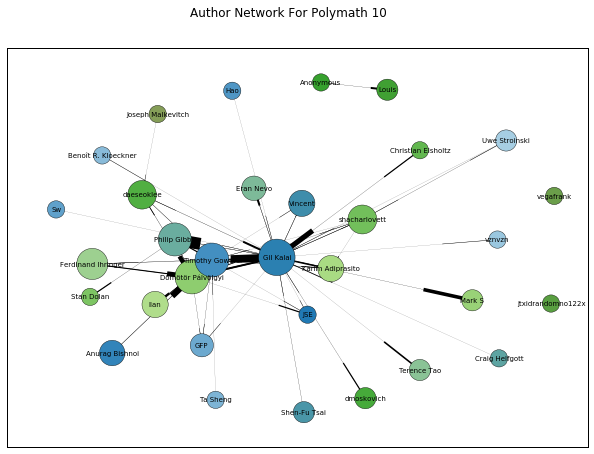

In [47]:
draw_network("Polymath 10")

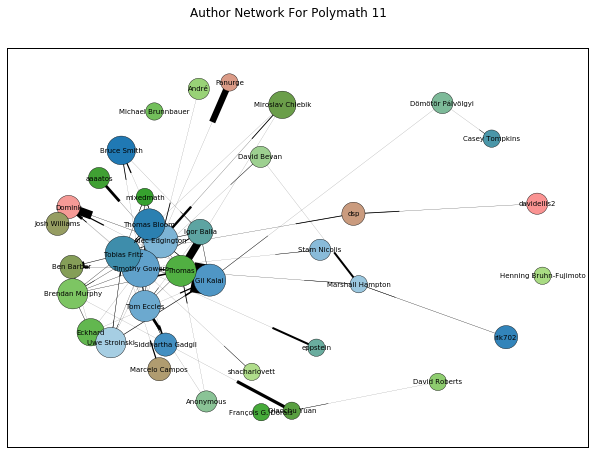

In [48]:
draw_network("Polymath 11")

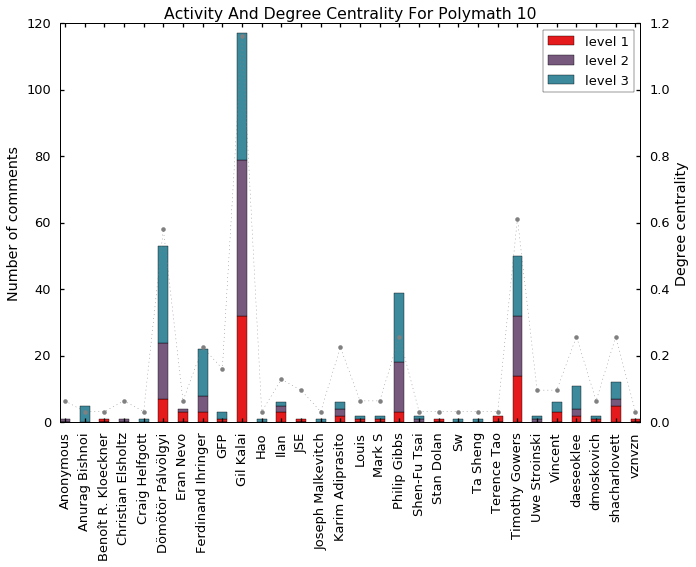

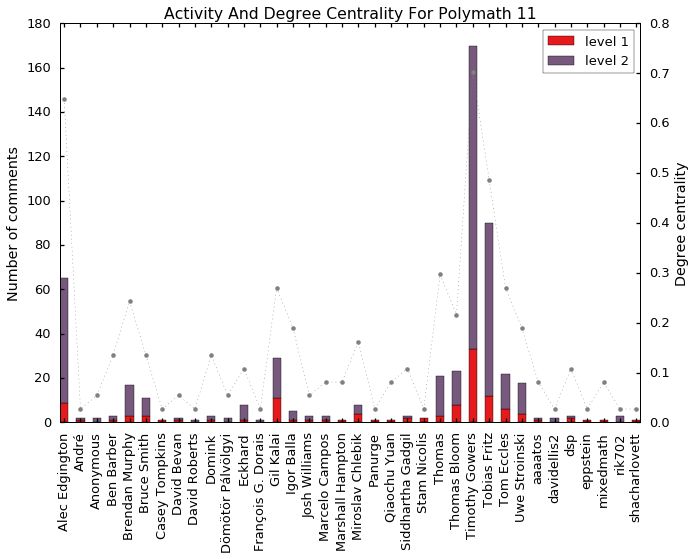

In [49]:
plot_activity_degree("Polymath 10")
plot_activity_degree("Polymath 11")

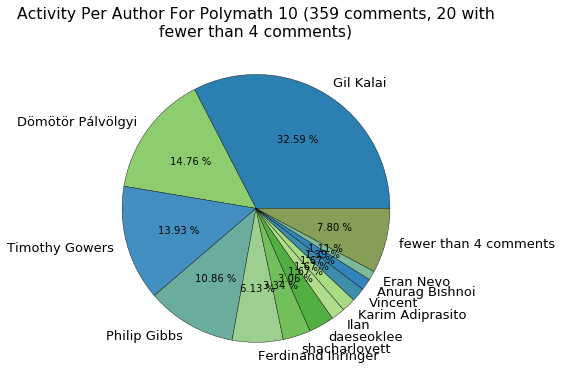

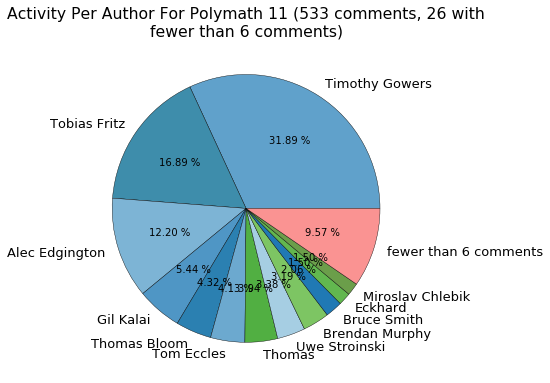

In [50]:
plot_activity_pie("Polymath 10")
plot_activity_pie("Polymath 11")

In [51]:
PM4_FRAME

title  \
Project    Ord                                                      
Polymath 4 0           Proposal: deterministic way to find primes   
           1    (Research thread II) Deterministic way to find...   
           2    (Research Thread III) Determinstic way to find...   
           3    (Research Thread IV) Determinstic way to find ...   
           4    (Research thread V) Determinstic way to find p...   
           5    Deterministic way to find primes: discussion t...   
           6                     Draft version of polymath4 paper   

                                                              url  \
Project    Ord                                                      
Polymath 4 0    http://polymathprojects.org/2009/07/27/proposa...   
           1    http://polymathprojects.org/2009/08/09/researc...   
           2    http://polymathprojects.org/2009/08/13/researc...   
           3    http://polymathprojects.org/2009/08/28/researc...   
           4    http://polymathprojects.org/2009/10/27/researc...   
           5    http://polymathprojects.org/2009/07/28/determi...   
           6    http://polymathprojects.org/2010/06/29/draft-v...   

                            blog research  number of comments  \
Project    Ord                                                  
Polymath 4 0    Polymathprojects     True                 130   
           1    Polymathprojects     True                 143   
           2    Polymathprojects     True                 114   
           3    Polymathprojects     True                  64   
           4    Polymathprojects     True                  40   
           5    Polymathprojects    False                  52   
           6    Polymathprojects    False                  31   

                number of comments (accumulated)  \
Project    Ord                                     
Polymath 4 0                                 130   
           1                                 273   
           2                                 387   
           3                                 451   
           4                                 491   
           5                                 543   
           6                                 574   

                                                           thread  \
Project    Ord                                                      
Polymath 4 0    <comment_thread.CommentThreadPolymath object a...   
           1    <comment_thread.CommentThreadPolymath object a...   
           2    <comment_thread.CommentThreadPolymath object a...   
           3    <comment_thread.CommentThreadPolymath object a...   
           4    <comment_thread.CommentThreadPolymath object a...   
           5    <comment_thread.CommentThreadPolymath object a...   
           6    <comment_thread.CommentThreadPolymath object a...   

                                                 mthread (single)  \
Project    Ord                                                      
Polymath 4 0    <comment_thread.MultiCommentThread object at 0...   
           1    <comment_thread.MultiCommentThread object at 0...   
           2    <comment_thread.MultiCommentThread object at 0...   
           3    <comment_thread.MultiCommentThread object at 0...   
           4    <comment_thread.MultiCommentThread object at 0...   
           5    <comment_thread.MultiCommentThread object at 0...   
           6    <comment_thread.MultiCommentThread object at 0...   

                                            mthread (accumulated)  \
Project    Ord                                                      
Polymath 4 0    <comment_thread.MultiCommentThread object at 0...   
           1    <comment_thread.MultiCommentThread object at 0...   
           2    <comment_thread.MultiCommentThread object at 0...   
           3    <comment_thread.MultiCommentThread object at 0...   
           4    <comment_thread.MultiCommentThread object at 0...   
           5    <comment_thread.Mu

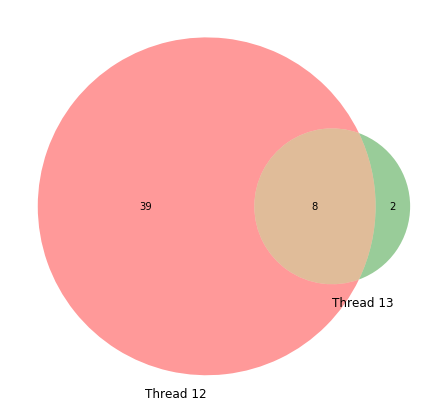

In [52]:

from matplotlib_venn import venn2, venn3
i=12
venn2([PM_FRAME.loc["Polymath 1"].iloc[i]['authors'],
               PM_FRAME.loc["Polymath 1"].iloc[i+1]['authors']],
              set_labels=['Thread {}'.format(i), 'Thread {}'.format(i+1)])

A first *pattern* that emerges is that Polymath 1 was indeed special in the following senses:
1. It reached more people
2. It led to more intense discussions
3. It created the core of the community

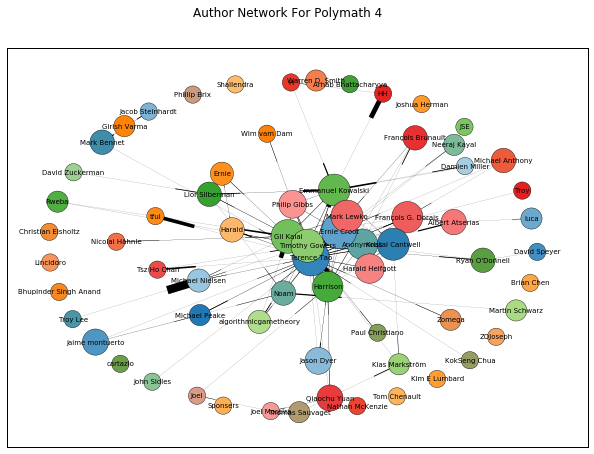

In [53]:
draw_network("Polymath 4")
end_pm4 = get_project_at("Polymath 4", -1)

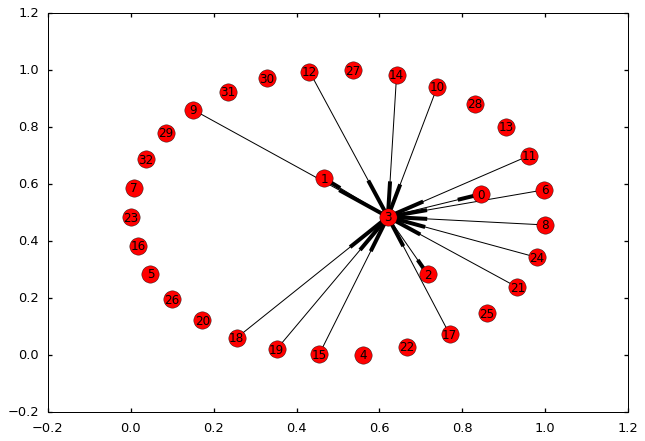

In [54]:
nx.draw_networkx(nx.condensation(end_pm4['network'].graph))

In [55]:
#from itertools import combinations
#AUTHOR_SETS = [PM_FRAME.loc[project]['authors (accumulated)'].iloc[-1] for
#               project in ("Polymath {}".format(i) for i in range(1, 3))]
#ALL_LINKS = list(chain.from_iterable(combinations(a_set, 2) for a_set in AUTHOR_SETS))
#len(ALL_LINKS)

In [56]:
#for link in ALL_LINKS:
#    if not link in BIG_NETWORK.edges():
#        BIG_NETWORK.add_edge(*link)

In [57]:
#ALL_LINKS = (tuple(product(PM_FRAME['authors'].iloc[i], PM_FRAME['authors'].iloc[i])) for i in range(len(PM_FRAME)))
#ALL_LINKS = (tuple(product(PM_FRAME['authors'].iloc[i], PM_FRAME['authors'].iloc[i])) for i in range(2))

#for links in ALL_LINKS:
#    for link in links:
#        if not link in BIG_NETWORK.edges():
#            BIG_NETWORK.add_edge(*link)

In [58]:
#positions = nx.spring_layout(BIG_NETWORK, k=10)
#nx.draw_networkx(BIG_NETWORK, positions, with_labels=True)
#nx.draw_shell(BIG_NETWORK)

In [59]:
#k_comps = nx.k_components(BIG_NETWORK)
#k_comps.values()

A problem with the above plots is that there is no way to connect threads to dates.

In [60]:
plot_community_engagement("Polymath 1", compress=150, sel=[4, 29])

NameError: name 'plot_community_engagement' is not defined

In [ ]:
draw_network("Polymath 5")
draw_network("Mini Polymath 2")

In [ ]:
plot_activity_pie("Polymath 5")
plot_activity_degree("Polymath 5")

## Comparing the sizes of the projects

In [ ]:
author_project.sum(axis=1).hist()

In [ ]:
PM1_AFRAME = PM_FRAME.loc['Polymath 1'].iloc[-1]['network'].author_frame
AFRAME = PM1_AFRAME[['word counts', 'total comments', 'replies (all)', 'degree centrality']]
pd.scatter_matrix(AFRAME[AFRAME['degree centrality'] != 0], diagonal='kde', color='k', alpha=0.3)

## Comparing projects and mini-projects

In [ ]:
mPM_FRAME['mthread (accumulated)'].iloc[3].plot_growth()

In [ ]:
urlparse("http://www.logicandinformation.be/index.html").path.split('/')[-1]

In [ ]:
draw_centre("Polymath 10")